# Simulate an arbitrary indictive dipole using qucat

## 1 Generating the circuit

This new features of qucat allows to insert an arbitrary purely inductive dipole, simplified at an arbitrary order. 

Using the general feature "Dipole" is only possible without specifying any energy : Only labels must be provided, so the values must be given when performing a specific calculation.

The plus sign shows the orientation of the dipole.


The number of labels the dipole has corresponds to the order at which it is simulated : Here there are 3 labels, so it will take into account the fourth first orders, as qucat usually does : 

$$U_{dipole}(\phi) = h(\frac{E2}{2!}\phi^2 + \frac{E3}{3!}\phi^3 + \frac{E4}{4!}\phi^4)$$

In this expression, the $Ei$ are provided in Hertz.

If this dipole is a Josephson element, we have, forgetting the constant term and expanding at order fourth :

$$U_{J}(\phi) = E_J(1 - \cos\phi) = \frac{E_J}{2}\phi^2 - \frac{E_J}{4!}\phi^4$$

So in this case : $E2 = \frac{E_J}{h}, E3 = 0, E4 = -\frac{E_J}{h}$.

Notes : 
- The dipoles are polarized, since odd orders are non zero in general. The orientation matters.
- One cannot set an element to strictly zero to prevent qucat errors. Provide very negligible values.



## 2 Hamiltonian

Once the hamiltonian decomposed into eigenmodes, the hamiltonian of the circuit writes :

$$ H = \sum_m{\hbar \omega_m \hat{a}^\dagger_m \hat{a}_m} + \sum_j \sum_{n\geq 3}\frac{\partial^{n} U_j}{\partial \phi^{n}}|_0\hat{\phi}_j^n$$

with :
- $\hat{\phi}_j$ being the phase across the j-th non linear element
- $m$ the modes of the circuit
- $\omega_m/2\pi$ the frequency of the $m$-th mode
- $\hat{a}_m$ the annihilator of the $m$-th mode
- $U_j(\phi)$ the inductive energy of the j-th non linear dipole, assuming its minimum is for $\phi = 0$


Using $\hat{\phi}_j =  \sum_m \phi_{zpf, m, j}\hat{\phi}_m = \sum_m \phi_{zpf, m, j}(\hat{a}^\dagger_m + \hat{a}_m)$ :

$$ H = \sum_m{\hbar \omega_m \hat{a}^\dagger_m \hat{a}_m} + \sum_j \sum_{n\geq 3}\frac{\partial^{n} U_j}{\partial \phi^{n}}[\sum_m \phi_{zpf, m, j}(\hat{a}^\dagger_m + \hat{a}_m)]^n$$


At fourth order, following qucat formalism (applying rotating wave approximation) and adding the third order term:

$$ H = \hbar\sum_m \big[( \omega_m - \sum_{n}\frac{\chi_{mn}}{2})\hat{a}_m^\dagger\hat{a}_m
-\frac{A_m}{2} \hat{a}_m^\dagger \hat{a}_m^\dagger \hat{a}_m \hat{a}_m 
-\sum_{n}\chi_{mn}\hat{a}_m^\dagger \hat{a}_m \hat{a}_n^\dagger \hat{a}_n\big] 
+ \sum_{m, n, o}(\gamma_{mno}^* \hat{a}_m^\dagger \hat{a}_n^\dagger \hat{a}_o + \gamma_{mno} \hat{a}_m \hat{a}_n \hat{a}_o^\dagger)$$

The modified version of qucat returns also the mixing terms $\gamma_{mno}$. Note that only the terms with $m\neq n, n\neq o, m\neq o$ are likely to conserve the energy.

For further orders, I added a function returning the full hamiltonian as a sympy expression. The simplifications using the rotating wawe approximation for example can then be perfomed afterwards.

## Example : the SNAIL

The SNAIL is a dipole containing three little Josephson juntions on one side, and one big on the other side :

<img src="graphics/SNAIL_scheme.png" width = "500"/>

*SNAIL scheme taken from N. E. Frattini, V. V. Sivak, A. Lingenfelter, S. Shankar et M. H. Devoret : Optimizing the Nonlinearity and Dissipation of a SNAIL Parametric Amplifier for Dynamic Range. Physical Review Applied, 10(5):1–17, 2018.*

Its inductive energy writes :

$$U_{SNAIL}(\phi) = -E_J(\alpha \cos\phi + 3 \cos \frac{\phi_0-\phi}{3})$$

It depends on :
- the flux bias in its loop
- a characteristic Josphson energy E_J
- a characteristic coeeficient $\alpha$

Having $\phi_0$, $E_J$ and $\alpha$, one can find the minimum of this inductive energy and develop it around it : The developpement will give the coeficient to feed qucat with :

$$U_{SNAIL}|_{\alpha, E, phi_{ext}}(\phi) = \frac{E2}{2}(\phi-\phi_{min})^2 + \frac{E3}{6}(\phi-\phi_{min})^3 + \frac{E4}{24}(\phi-\phi_{min})^4$$

In [5]:
from scipy.constants import *
import matplotlib.pyplot as plt
from scipy.optimize import *
import numpy as np
import sympy as sp
import qucat as qc


## Parameters for the circuit
order = 4 #order at which the SNAIL will be expanded
alpha = 0.12
phi_0 = h/(2*e) #the flux quantum
L = 1e-8 #the Jospehson inductance of the small junctions
E_J = 1/h*phi_0**2/(4*pi)**2/L #the Josephson energy of the small junctions, in Hz
C1 = 10e-14 #capacities of the circuit
C2 = 15e-14
C3 = 20e-14



#We use sympy to create the derivatives of the energy 
phi = sp.Symbol("phi")
a = sp.Symbol("a")
E = sp.Symbol("E")
phi_ext = sp.Symbol("phi_ext")

U_sym = -E*(a*sp.cos(phi) + 3*sp.cos((phi_ext-phi)/3))
dnU_sym =[sp.diff(U_sym, phi, i) for i in range(order+1)]#Symbolic expression for the derivatives
dnU = [sp.lambdify([phi, E, a, phi_ext], c) for c in dnU_sym] #creates the python functions for the derivatives:
#dnU[i](E, a, phi_ext, phi)


def make_dict(E, a, phi_ext): #constructs the dictionnary to give as keyword arguments
    labels = {"C1":C1, "C2":C2, "C3":C3, "L":L}
    phi_min = (minimize(dnU[0], 11, method = 'L-BFGS-B' , bounds = [(-1, 7*np.pi)],args = (1, alpha, phi_ext)).x)[0]%(6*np.pi) #The point from which the potential will be expanded
    for i,c in enumerate(dnU[2::]):
        labels["E"+str(i+2)] = E*c(1, a, phi_ext, phi_min)
    return labels

def make_dict_vect(E, a, phi_ext): #same function but vectorized, to sweep phi_ext
    labels = {"C1":[C1 for c in phi_ext], 
              "C2":[C2 for c in phi_ext], 
              "C3":[C3 for c in phi_ext], 
              "L":[L for c in phi_ext]}
    for i, c in enumerate(dnU[2::]): #initialisation of the lists
        labels["E"+str(i+2)] = []

    phi_min = [0]

    for c in phi_ext:
        phi_min.append((minimize(dnU[0], 11, method = 'L-BFGS-B' , bounds = [(-1, 7*np.pi)],args = (1, alpha, c)).x)[0]%(6*np.pi))
    phi_min.pop(0) #I struggled with the optimization, these parameters work for this example.
    
    for i,c in enumerate(phi_min):
        for j, d in enumerate(dnU[2::]):
            labels["E"+str(j+2)] = labels["E"+str(j+2)]+[d(c, E, a, phi_ext[i])]
    return labels

At this point, one can simply need to construct the circuit (the one given in 'Generating the circuit", with every element being given a label, not a value :

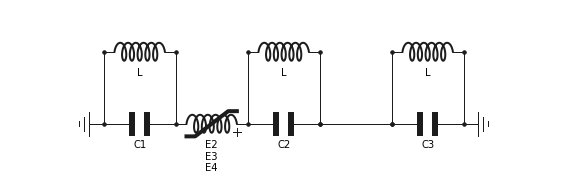

In [6]:
circuit = qc.GUI("circuits/snail.txt", edit=False)

Let's check the evolution of the derivatives at the minimum as a function of $\phi_{ext}$ :

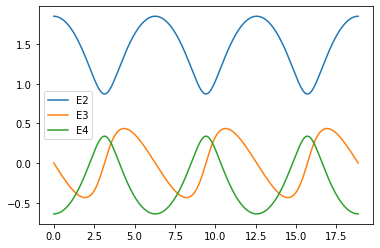

In [7]:
phi_exts = np.linspace(0,6*np.pi, 1000)

labels = make_dict_vect(E_J, alpha, phi_exts) #labels is a dictionnary where each key corresponds to a list of values

plt.plot(phi_exts, np.array(labels["E2"])/1e9, label = "E2")
plt.plot(phi_exts, np.array(labels["E3"])/1e9,  label = "E3")
plt.plot(phi_exts, np.array(labels["E4"])/1e9,  label = "E4")
plt.legend()

The unbiased SNAIL has no third order term since it's has a parity in the flux.
Let's look at the frequencies, given by E2 :

C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[[<matplotlib.lines.Line2D at 0x2601b708a00>],

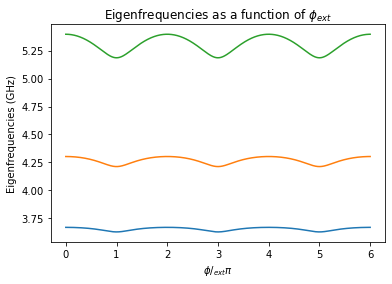

In [8]:
freqs = circuit.eigenfrequencies(**labels)/1e9

plt.xlabel(r"$\phi/_{ext}\pi}$")
plt.ylabel("Eigenfrequencies (GHz)")
plt.title("Eigenfrequencies as a function of $\phi_{ext}$")
[plt.plot(phi_exts/np.pi, c) for c in freqs]


They follow the evolution of E2, which is expected.

Let's look at the three waves mixing term :

C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


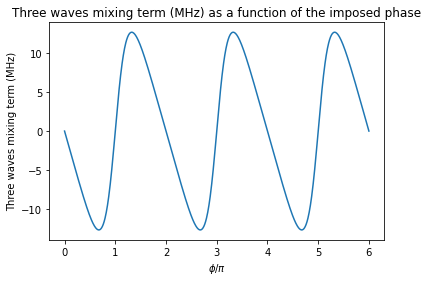

In [9]:
three_waves = circuit.three_waves(0, 1, 2, **labels)/1e6 #In MHz

plt.xlabel(r"$\phi/\pi}$")
plt.ylabel("Three waves mixing term (MHz)")
plt.title("Three waves mixing term (MHz) as a function of the imposed phase")
plt.plot(phi_exts/np.pi, three_waves)


It has the same shape as the E3 term.

And now, the self-Kerr terms : 

No handles with labels found to put in legend.
C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\gely\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


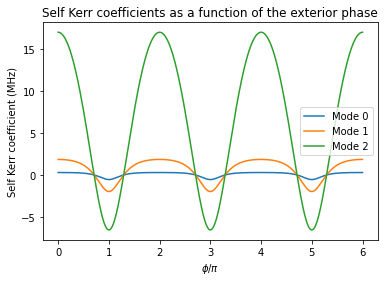

In [10]:
kerr_coeffs = circuit.kerr(**labels)/1e6 # in MHz


plt.xlabel(r"$\phi/\pi}$")
plt.ylabel("Self Kerr coefficient (MHz)")
plt.title("Self Kerr coefficients as a function of the exterior phase")
plt.legend()
[plt.plot(phi_exts/np.pi, kerr_coeffs[i, i], label = "Mode "+ str(i)) for i in range(len(kerr_coeffs))]
plt.legend()


We can clearly see the existence of the sweet spot, point where all the Kerr terms vanish, but the three waves mixing term still exists, allowing to make a parametric amplifier without beeing limited by the Kerr terms, cf *SNAIL scheme taken from N. E. Frattini, V. V. Sivak, A. Lingenfelter, S. Shankar et M. H. Devoret : Optimizing the Nonlinearity and Dissipation of a SNAIL Parametric Amplifier for Dynamic Range. Physical Review Applied, 10(5):1–17, 2018.*

The other features of qucat apply otherwise : the f_k_A_chi function, getting the full hamiltonian with qutip. It is now possible to get the hamiltonian with sympy :

In [11]:
circuit.hamiltonian_sym(**make_dict(E_J, alpha, np.pi/7), modes = 'all') 

-2268433.90807212*(-0.723217902731606*(AnnihilateBoson(m0) + CreateBoson(m0)) - 0.854359675570133*(AnnihilateBoson(m1) + CreateBoson(m1)) + AnnihilateBoson(m2) + CreateBoson(m2))**3 - 161131.306392276*(-0.723217902731606*(AnnihilateBoson(m0) + CreateBoson(m0)) - 0.854359675570133*(AnnihilateBoson(m1) + CreateBoson(m1)) + AnnihilateBoson(m2) + CreateBoson(m2))**4 + 3586103050.64838*CreateBoson(m0)*AnnihilateBoson(m0) + 4144027457.78342*CreateBoson(m1)*AnnihilateBoson(m1) + 5077766571.67969*CreateBoson(m2)*AnnihilateBoson(m2)

Note that the expression isn't simplified, and uses the bosonic operators from the sympy.physics.secondquant library. To simplify it (normal ordering for example), one needs to further analyse it by themselves, I didn't found any built-in function to do this with bosonic operators (it exists for fermionic operators though).

The Keywords arguments are the same as for the hamiltonian function that works with qutip. However, to further Taylor expand the hamiltonian, one should have specified the corresponding number of labels for each arbitray dipole in the circuit. In our example, we cannot go further than the fourth order, unless we decide to provide more labels.

One can also, for example, select the modes to be taken into account.